# Lesson: Logistic Regression

<hr style="border:2px solid gray">

<b>Here is a presentation about Logistic Regression. Take a look!</b>

[Logistic Regression Slide Deck by Madeleine](https://www.canva.com/design/DAEfWtGKNgc/VqwX9iLNaf4TV7YJg6XflQ/view?utm_content=DAEfWtGKNgc&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton)

## Hyperparameters
### Regularization:
- Keep model simple
- Constraints the coefficients
- Discourages learning more complex model
- Minimizes overfitting
- L1 - Lasso
- L2 - Ridge

### C = Inverse of regularization strength:
- Lower C - higher regularization
- Lower C discourages learning more complex model
- minimizes overfitting

In [1]:
#standard DS imports
import pandas as pd
import numpy as np

#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

#acquire data
from pydataset import data

#quite warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:1.5px solid black">

## Acquire:

In [2]:
#bring in our csv
st_df = pd.read_csv('~/Downloads/space_titanic.csv')

In [3]:
#take a look at the data
st_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
#what kind of columns and dataframes are we dealing with?
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Prepare:

In [5]:
#it looks like there are a few nulls- let's get rid of those 
st_df = st_df.dropna()

In [6]:
#create list of columns that we want to drop
columns_to_drop = ['Cabin', 'Name']

In [7]:
#drop those columns and save changes using inplace kwarg
st_df.drop(columns=columns_to_drop, inplace=True)

In [8]:
#create dummy columns for homeplanet and destination
dummies = pd.get_dummies(st_df[['HomePlanet', 'Destination']],drop_first=True)

In [9]:
#assign combined df to st_df
st_df = pd.concat([st_df, dummies], axis=1)

In [10]:
#make sure we have all the data
st_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,0,0,1
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,0,0,1
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1,0,0,1
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,0,0,1
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0,0,0,1


In [11]:
#let's drop the original columns
st_df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

In [12]:
st_df['Transported'] = np.where(st_df['Transported'] == True, 'True', 'False')

## Split Data:

In [13]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [14]:
#split the data using our function above (stratify on our target variable)
train, validate, test = train_validate_test_split(st_df, 'Transported')

In [15]:
#take a look at the data
train.shape, validate.shape, test.shape

((3698, 14), (1586, 14), (1322, 14))

## Isolate the target

In [16]:
#pull our target out!
X_train = train.drop(columns=['Transported'])
#assign y
y_train = train['Transported']

#pull our target out!
X_val = validate.drop(columns=['Transported'])
#assign y
y_val = validate['Transported']

#pull our target out!
X_test = test.drop(columns=['Transported'])
#assign y
y_test = test['Transported']

## Model 1:

<div class="alert alert-block alert-info">
<b>Steps of Modeling:</b>
<br>
<br>
1. Create the model
    <br>
2. Fit the model
    <br>
3. Use the model
</div>

### Create the model

In [17]:
#create model 1
logit = LogisticRegression()

### Fit the model

In [18]:
#fit the model on train data
logit.fit(X_train, y_train)

LogisticRegression()

<b>Make the predictions</b>

In [20]:
#now use the model to make predictions
y_pred = logit.predict(X_train)
y_pred

array(['True', 'True', 'True', ..., 'True', 'True', 'True'], dtype=object)

<b>Estimate Probability</b>

In [21]:
#probability of predicting correctly
y_pred_proba = logit.predict_proba(X_train)
y_pred_proba

array([[0.36715407, 0.63284593],
       [0.34614657, 0.65385343],
       [0.366821  , 0.633179  ],
       ...,
       [0.45216142, 0.54783858],
       [0.29277768, 0.70722232],
       [0.44889782, 0.55110218]])

In [57]:
# View raw probabilities (output from the model)
y_pred_proba = logit.predict_proba(X_train)
y_pred_proba = pd.DataFrame(y_pred_proba)
columns = ['Non-Transported', 'Transported']

In [58]:
y_pred_proba.head()

,0,1
0,0.367154,0.632846
1,0.346147,0.653853
2,0.366821,0.633179
3,0.918890,0.081110
4,0.480027,0.519973


### Evaluate the model

<b>Compute Accuracy</b>

In [69]:
mod1_score = logit.score(X_train, y_train)

In [70]:
print(f'The accuracy of model 1 is {mod1_score}')

The accuracy of model 1 is 0.7758247701460249


## Model 2

In [28]:
seed=42
logit2 = LogisticRegression(penalty='l1', random_state=seed, solver='liblinear', max_iter=200)

In [29]:
logit2.fit(X_train, y_train)

LogisticRegression(max_iter=200, penalty='l1', random_state=42,
                   solver='liblinear')

In [71]:
mod2_score = logit2.score(X_train, y_train)

In [72]:
print(f'The accuracy of model 2 is {mod2_score}')

The accuracy of model 2 is 0.780151433207139


## Validate Model
This is our out-of-sample data

<div class="alert alert-block alert-info">
<b>Remember:</b>
<br>
<br>
Be sure to remind the student that they are <b>not</b> to refit the model
</div>

In [31]:
logit2.score(X_val, y_val)

0.7976040353089533

In [33]:
y_pred = logit2.predict(X_val)
y_pred

array(['False', 'False', 'False', ..., 'True', 'True', 'True'],
      dtype=object)

In [41]:
#probability that the outcome is the true class
proba_array = logit2.predict_proba(X_val)

In [ ]:
proba_array

In [42]:
proba_array[0]

array([0.88546524, 0.11453476])

In [40]:
logit2.classes_

array(['False', 'True'], dtype=object)

In [44]:
#calling the probability of each row
proba_array[0][1]

0.11453476236540631

In [45]:
#probability that the outcome is the true class for each element in this array
for row in proba_array:
    print(row[1])

0.11453476236540631
0.34385941985182916
1.776950712978669e-07
0.5122786526551317
0.012928350301284641
0.02862992534839578
0.16672351497543905
0.2252676108831603
0.9642209698239681
0.5400610212895112
0.20601518233268334
0.10347807355586347
0.4046720258550391
0.7478966352525678
0.9408490187974202
0.3468328158044314
0.6739491077678235
0.8258087349251537
0.3190296864455793
0.8286054508769801
0.7062587800653081
0.25372398714837624
0.2026760666630284
0.5922504390713363
0.7119669100313964
0.940280641803075
0.9202780517093462
0.8171823679041278
0.7895216972445006
0.7111200433293734
0.006004711900338793
0.28115197192016583
0.818807553285086
0.15037841485305792
0.6698436346268551
0.6035704187305171
0.3801192970224025
0.7169639879322934
0.23409135140777093
0.700870533864168
0.2786470096807901
0.0510727008141086
0.33418331169197435
0.4130886149925025
0.8312410172227702
0.1839656443853298
0.8469348799023848
0.4009836218979357
0.5245984328865185
0.3641395529233756
0.7013211776113573
0.01038661939961

In [46]:
#probability of values being true
proba_true = np.array([row[1] for row in proba_array])

#take a look at first 5
proba_true[:5]

array([1.14534762e-01, 3.43859420e-01, 1.77695071e-07, 5.12278653e-01,
       1.29283503e-02])

## Evaluate Model 1 and Model 2 performance on 'Validate'

In [74]:
#Model 1
print(classification_report(y_val, logit.predict(X_val)))

              precision    recall  f1-score   support

       False       0.87      0.65      0.75       787
        True       0.73      0.90      0.81       799

    accuracy                           0.78      1586
   macro avg       0.80      0.78      0.78      1586
weighted avg       0.80      0.78      0.78      1586



In [75]:
#Model 2
print(classification_report(y_val, logit2.predict(X_val)))

              precision    recall  f1-score   support

       False       0.80      0.79      0.79       787
        True       0.79      0.81      0.80       799

    accuracy                           0.80      1586
   macro avg       0.80      0.80      0.80      1586
weighted avg       0.80      0.80      0.80      1586



<b>Create a dataframe of probability being true and actual values</b>

In [49]:
graph_df = pd.DataFrame({'proba_true': proba_true,
                         'actual_label': y_val})

In [50]:
graph_df

,proba_true,actual_label
4680,1.145348e-01,False
4882,3.438594e-01,False
490,1.776951e-07,False
882,5.122787e-01,False
7466,1.292835e-02,False
...,...,...
8290,6.542025e-01,False
7550,4.528803e-01,True
2085,5.069271e-01,False
7666,7.342936e-01,True


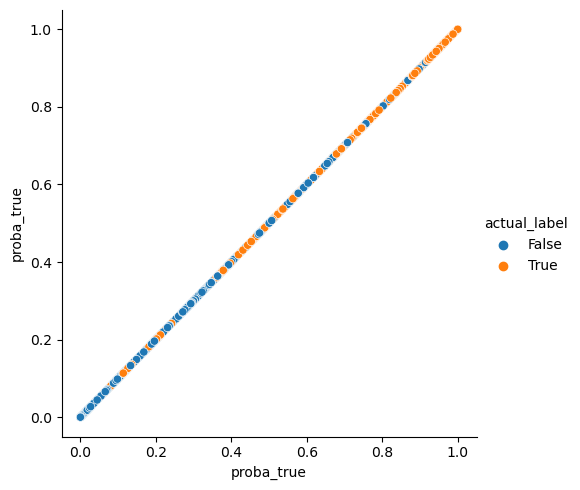

In [51]:
sns.relplot(data= graph_df, x='proba_true', y= 'proba_true', hue= 'actual_label')

<hr style="border:1.5px solid black">

## Bonus: Interpreting model coefficients

In [ ]:
#Take a look at the coeffiecents for model 1
logit.coef_[0]

<b>Logistic Regression basics:<b>
    
log(odds) = log(p/(1-p)) = $intercept$ + ( $β_1$* variable1) + ( $β_2$* variable2) + ( $β_3$* variable3)

<b>The coefficients above represents 'log odds'</b>

In [77]:
# Make a dataframe of coefficients and feature names
pd.DataFrame({'column': X_train.columns.tolist(),
             'coefficient': logit.coef_[0]})

,column,coefficient
0,PassengerId,1.119354e-06
1,CryoSleep,4.450122e-06
2,Age,1.660111e-05
3,VIP,-7.934014e-08
4,RoomService,-1.590534e-03
5,FoodCourt,8.269247e-04
6,ShoppingMall,2.267902e-04
7,Spa,-2.171439e-03
8,VRDeck,-2.047744e-03
9,HomePlanet_Europa,2.465989e-06


<div class="alert alert-block alert-info">
<b>Note:</b>
<br>
<br>
It would be helpful to convert 'log odds' to 'odds.
<br>
Let's do this now using np.exp
<br>
    
<b>np.exp</b>: Calculates the exponential of all elements in the input array.
</div>

In [78]:
# convert from log odds to odds (exponentiate)
odds = np.exp(log_coeffs)

In [79]:
#take a look at what the odds are
odds

,coeff
PassengerId,1.000001
CryoSleep,1.000004
Age,1.000017
VIP,1.000000
RoomService,0.998411
FoodCourt,1.000827
ShoppingMall,1.000227
Spa,0.997831
VRDeck,0.997954
HomePlanet_Europa,1.000002


<b>Coefficient Interpretation (odds):</b>
- Example: petal_length: For every one unit increase in petal_length, we expect 10 times increase in odds of being a 'virginica' vs a 'non-virginica'.

- If the coefficient (odds) is 1 or close to 1, this means odds of being in class '1' (positive class) is same or close to being in class '0' (negative class). This means the feature with this coefficient is not a big driver for the target variable in this particular model

- If the coefficient value is < 1 , that implies that increase in value of that feature will decrease the odds that target variable is in positive class